In [133]:
import os
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# loading python packages and files from repo root
if Path(os.getcwd()).name != "SSL4EO_base":
    os.chdir("..")

from main import METHODS
from data import constants
from data.constants import MMEARTH_DIR, input_size
from data.mmearth_dataset import MMEarthDataset, create_MMEearth_args, get_mmearth_dataloaders

## Init Model

In [19]:
# load model from checkpoint
method = "barlowtwins"
model_path = "/work/data/weights/barlowtwins/50epochs" # replace with your own path to data

In [20]:
model_ckpt = torch.load(model_path, map_location="cpu") # no gpu required for running small samples

In [21]:
model_ckpt["hyper_parameters"]

{'backbone': 'default',
 'batch_size_per_device': 512,
 'in_channels': 12,
 'num_classes': 14,
 'has_online_classifier': True,
 'last_backbone_channel': None,
 'method': 'BarlowTwins'}

In [29]:
# intialize model from checkpoint hyper parameters
hparams = model_ckpt["hyper_parameters"]
model = METHODS[method]["model"](
    backbone=hparams["backbone"], 
    batch_size_per_device=hparams["batch_size_per_device"], 
    in_channels=hparams["in_channels"], 
    num_classes=hparams["num_classes"], 
    has_online_classifier=hparams["has_online_classifier"], 
    last_backbone_channel=hparams["last_backbone_channel"], 
    train_transform=METHODS[method]["transform"]
)

Using default backbone: resnet50


In [30]:
model.load_state_dict(model_ckpt["state_dict"])

<All keys matched successfully>

## Init Dataset

In [32]:
# initialize dataset
modalities = constants.INP_MODALITIES
split = "train"
args = create_MMEearth_args(MMEARTH_DIR, modalities, {"biome": constants.MODALITIES_FULL["biome"]})

dataset = MMEarthDataset(args, split=split)

## Retrieve Representation

In [118]:
num_samples = 1000

# choosing a random sample and saving biome and sentinel 2
s2 = []
biome = []
for idx in range(num_samples):
    data = dataset[idx]
    s2.append(torch.from_numpy(data["sentinel2"]))
    biome.append(data["biome"])

# stack to shape: b, c, h, w
s2 = torch.stack(s2, 0)

# concatentate to shape: b
biome = np.stack(biome, 0)

In [119]:
s2.shape

torch.Size([1000, 12, 128, 128])

In [120]:
biome.shape

(1000,)

In [121]:
# retrieve learned representation z
with torch.no_grad():
    model.eval()
    z = model(s2).flatten(start_dim=1)

In [122]:
z.shape

torch.Size([1000, 2048])

## Feature Covariance

In [123]:
from lightly.loss.vicreg_loss import covariance_loss, variance_loss

In [124]:
covariance_loss(z)

tensor(1.0900)

In [125]:
variance_loss(z)

tensor(0.4848)

## PCA

In [126]:
from sklearn.decomposition import PCA

In [141]:
n_components = 1000
pca = PCA(n_components)

In [142]:
transformed_z = pca.fit_transform(z.numpy())

In [143]:
cmap = sns.color_palette("Set2", np.unique(biome).shape[0], as_cmap=True)

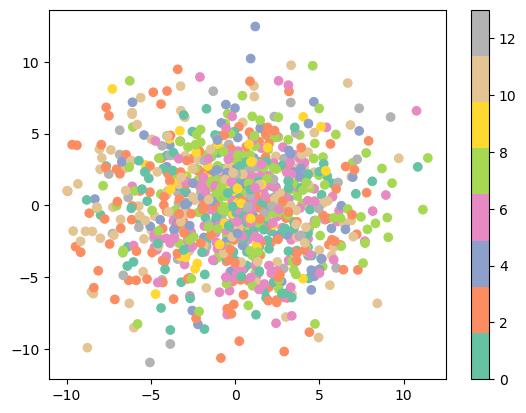

In [144]:
# plot first 2 principle components and use biome to color samples)
plt.scatter(transformed_z[:, 0], transformed_z[:, 1], c=biome, cmap=cmap)
plt.colorbar()

<BarContainer object of 1000 artists>

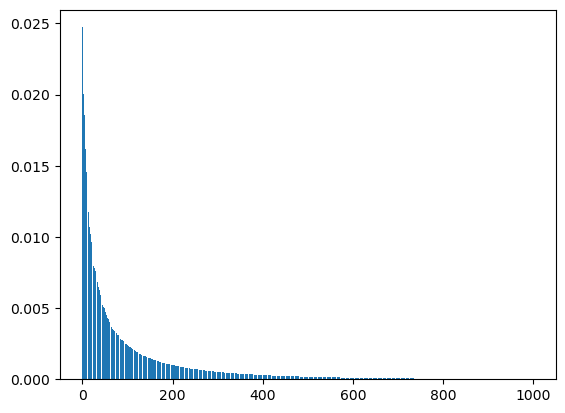

In [148]:
plt.bar(range(n_components), pca.explained_variance_ratio_)

## UMAP

In [154]:
from umap import UMAP

In [156]:
umap = UMAP()

In [157]:
transformed_z = umap.fit_transform(z)

In [159]:
cmap = sns.color_palette("Set2", np.unique(biome).shape[0], as_cmap=True)

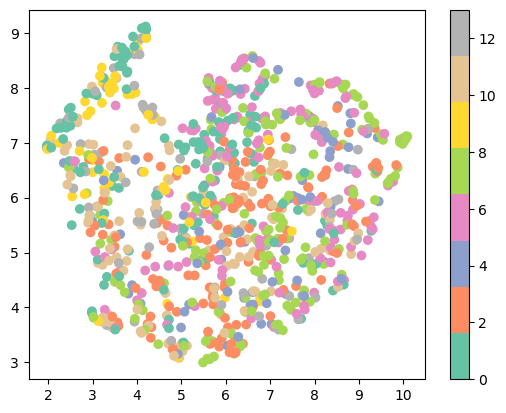

In [160]:
# plot first 2 principle components and use biome to color samples)
plt.scatter(transformed_z[:, 0], transformed_z[:, 1], c=biome, cmap=cmap)
plt.colorbar()